## Redes Neurais Artificiais 2025.1

- **Disciplina**: Redes Neurais Artificiais 2025.1  
- **Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)  
- **Github**: http://github.com/elloa  

|Alunos                |Matrícula  |
|----------------------|-----------|
|Caio Bertoldo         |2215080050 |
|Danilo Jorge          |2215080007 |
|Diogo Gomes           |2215080033 |
|Guilherme Montenegro  |2215080011 |
|Leonardo Abinader     |2215080042 |
|Rodolfo Simões        |2215080073 |

## Busca em Grade com Validação Cruzada

In [1]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from joblib import Parallel, delayed
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Carregar o dataset
df = pd.read_csv('datasets/updated_pollution_dataset_scaled.csv')

# Separar as variáveis independentes (X) e a variável dependente (y)
X = df.drop(columns=['Air Quality Encoded'])
y = df['Air Quality Encoded']

### Propondo arquiteturas

In [3]:
# Regra da Pirâmide Geométrica
alpha = [0.5, 1, 1.5, 2]

n = round((X.shape[1] * len(y.unique()))**0.5)
nh = [int(n * a) for a in alpha]
nh

[3, 6, 9, 12]

### Método Holdout

In [4]:
# Arquiteturas e hiperparâmetros
architectures = [(3,), (2, 1), 
                (6,), (4, 2), (5, 1),
                (9,), (5, 4), (6, 3), (7, 2), (8, 1),
                (12,), (7, 5), (8, 4), (9, 3), (10, 2), (11, 1)]
functions = ['relu']

solvers = ['adam', 'sgd']

epochs = [300]

grid_holdout = list(product(architectures, functions, solvers, epochs))

In [5]:
# Função para treinar e avaliar o modelo
def treino_e_avaliacao(X, y, grid):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    mlp = MLPClassifier(
        hidden_layer_sizes = grid[0],
        activation = grid[1],
        solver = grid[2],
        max_iter = grid[3],
        verbose = False
    )

    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    return acc, prec, rec, f1, cm, y_test, y_pred, mlp

In [10]:
# Função para pegar as 3 melhores redes
def get_top3(overall_averages, grid):
    top3 = sorted(overall_averages, key = lambda av: (av[1], av[0]), reverse = True)[:3]

    print("\nTop-3 modelos por Acurácia e F1-score (médias):\n")

    for i, (f1, acc, prec, rec, idx, _, _, _, _) in enumerate(top3):
        print(f"Top {i + 1}: Arquitetura {idx}: Modelo = {grid[idx]}")
        print(f"Acurácia = {acc:.4f} | Precisão: {prec:.4f} | Revocação: {rec:.4f} | F1-score =  {f1:.4f} |\n")

    return top3

In [7]:
# Resultados detalhados para análise posterior
media_geral_arquiteturas = []
resultados_detalhados = []


for idx, model in enumerate(grid_holdout):
    print(f"Executando modelo {idx + 1}/{len(grid_holdout)}: {model}")

    resultados = Parallel(n_jobs = -1)(delayed(treino_e_avaliacao)(X, y, model) for _ in range(100))

    acuracias = [r[0] for r in resultados]
    precsisoes = [r[1] for r in resultados]
    revocacoes = [r[2] for r in resultados]
    f1_scores = [r[3] for r in resultados]

    # Melhor execução com base em F1 (desempate por acurácia)
    melhor_resultado = max(resultados, key = lambda r: (r[3], r[0]))
    acc, prec, rec, f1, cm, y_test, y_pred, mlp_model = melhor_resultado

    media_acc = np.mean(acuracias)
    media_prec = np.mean(precsisoes)
    media_rec = np.mean(revocacoes)
    media_f1 = np.mean(f1_scores)
    desvio_acc = np.std(acuracias)
    desvio_prec = np.std(precsisoes)
    desvio_rev = np.std(revocacoes)
    desvio_f1 = np.std(f1_scores)

    # acc_from_100, f1_from_100, cm, ytest_from_100, ypred_from_100, mlp_from_100 = zip(*resultados)

    # Armazenar resultados
    media_geral_arquiteturas.append((media_f1, media_acc, media_prec, media_rec, idx, desvio_f1, desvio_acc, desvio_prec, desvio_rev))
    resultados_detalhados.append({
        'modelo': model,
        'acuracia': acc,
        'precisao': prec,
        'revocacao': rec,
        'f1_score': f1,
        'cm': cm,
        'y_test': y_test,
        'y_pred': y_pred
    })

Executando modelo 1/32: ((3,), 'relu', 'adam', 300)
Executando modelo 2/32: ((3,), 'relu', 'sgd', 300)
Executando modelo 3/32: ((2, 1), 'relu', 'adam', 300)
Executando modelo 4/32: ((2, 1), 'relu', 'sgd', 300)
Executando modelo 5/32: ((6,), 'relu', 'adam', 300)
Executando modelo 6/32: ((6,), 'relu', 'sgd', 300)
Executando modelo 7/32: ((4, 2), 'relu', 'adam', 300)
Executando modelo 8/32: ((4, 2), 'relu', 'sgd', 300)
Executando modelo 9/32: ((5, 1), 'relu', 'adam', 300)
Executando modelo 10/32: ((5, 1), 'relu', 'sgd', 300)
Executando modelo 11/32: ((9,), 'relu', 'adam', 300)
Executando modelo 12/32: ((9,), 'relu', 'sgd', 300)
Executando modelo 13/32: ((5, 4), 'relu', 'adam', 300)
Executando modelo 14/32: ((5, 4), 'relu', 'sgd', 300)
Executando modelo 15/32: ((6, 3), 'relu', 'adam', 300)
Executando modelo 16/32: ((6, 3), 'relu', 'sgd', 300)
Executando modelo 17/32: ((7, 2), 'relu', 'adam', 300)
Executando modelo 18/32: ((7, 2), 'relu', 'sgd', 300)
Executando modelo 19/32: ((8, 1), 'relu'


Top-3 modelos por Acurácia e F1-score (médias):

Top 1: Arquitetura 26: Modelo = ((9, 3), 'relu', 'adam', 300)
Acurácia = 0.9435 | Precisão: 0.9214 | Revocação: 0.9134 | F1-score =  0.9170 |

Top 2: Arquitetura 20: Modelo = ((12,), 'relu', 'adam', 300)
Acurácia = 0.9428 | Precisão: 0.9211 | Revocação: 0.9122 | F1-score =  0.9163 |

Top 3: Arquitetura 24: Modelo = ((8, 4), 'relu', 'adam', 300)
Acurácia = 0.9427 | Precisão: 0.9202 | Revocação: 0.9126 | F1-score =  0.9160 |


Top 1 - Modelo: ((9, 3), 'relu', 'adam', 300)
Acurácia: 0.9520
Precisão: 0.9377
Revocação: 0.9265
F1-Score: 0.9317


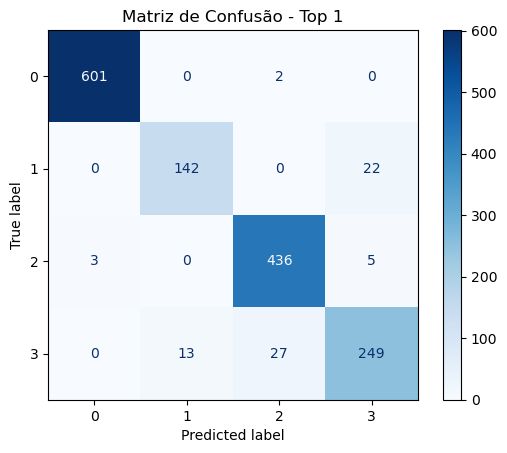


Top 2 - Modelo: ((12,), 'relu', 'adam', 300)
Acurácia: 0.9553
Precisão: 0.9395
Revocação: 0.9316
F1-Score: 0.9354


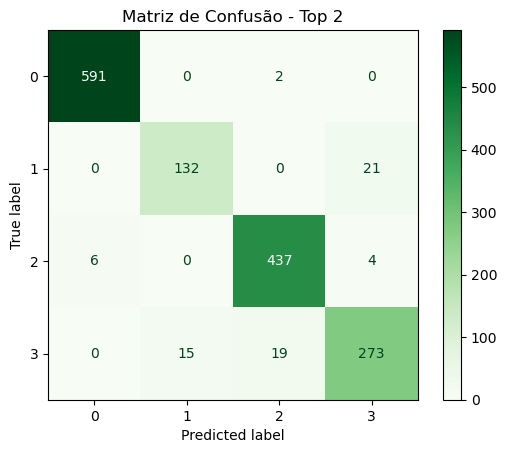


Top 3 - Modelo: ((8, 4), 'relu', 'adam', 300)
Acurácia: 0.9520
Precisão: 0.9364
Revocação: 0.9249
F1-Score: 0.9303


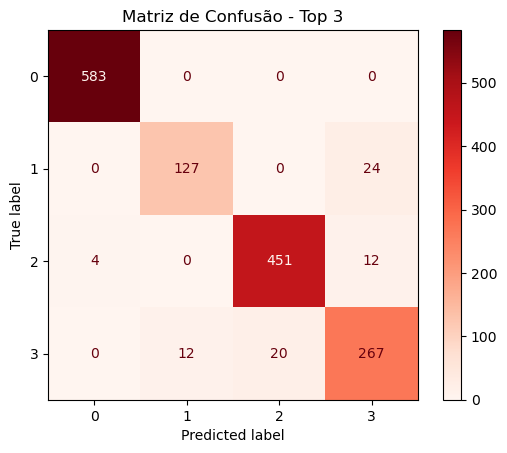

In [11]:
# Mostra top-3 com matrizes
top3_resultados = get_top3(media_geral_arquiteturas, grid_holdout)

# Exibir matrizes de confusão para as 3 melhores
cmaps = ['Blues', 'Greens', 'Reds']

for i, (_, _, _, _, idx, _, _, _, _) in enumerate(top3_resultados):
    melhor = resultados_detalhados[idx]
    print(f"\nTop {i + 1} - Modelo: {melhor['modelo']}")
    print(f"Acurácia: {melhor['acuracia']:.4f}")
    print(f"Precisão: {melhor['precisao']:.4f}")
    print(f"Revocação: {melhor['revocacao']:.4f}")
    print(f"F1-Score: {melhor['f1_score']:.4f}")
    disp = ConfusionMatrixDisplay.from_predictions(melhor['y_test'], melhor['y_pred'], cmap = cmaps[i])
    disp.ax_.set_title(f'Matriz de Confusão - Top {i + 1}')
    plt.show()

### Método K-Fold

In [12]:
# Grid de parâmetros
param_grid = {
    'hidden_layer_sizes': [(3,), (2, 1), 
                        (6,), (4, 2), (5, 1),
                        (9,), (5, 4), (6, 3), (7, 2), (8, 1),
                        (12,), (7, 5), (8, 4), (9, 3), (10, 2), (11, 1)],
    'activation': ['relu'],
    'solver': ['adam', 'sgd'],
    'max_iter': [300]
}

In [13]:
# Busca em Grade com 5-Fold
grid_cv = GridSearchCV(MLPClassifier(), 
                       param_grid, 
                       cv = 10,
                       scoring = 'f1_macro',
                       n_jobs = -1,
                       verbose = 2)

In [17]:
grid_cv.fit(X, y)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


GridSearchCV(cv=10, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu'],
                         'hidden_layer_sizes': [(3,), (2, 1), (6,), (4, 2),
                                                (5, 1), (9,), (5, 4), (6, 3),
                                                (7, 2), (8, 1), (12,), (7, 5),
                                                (8, 4), (9, 3), (10, 2),
                                                (11, 1)],
                         'max_iter': [300], 'solver': ['adam', 'sgd']},
             scoring='f1_macro', verbose=2)

In [18]:
results = pd.DataFrame(grid_cv.cv_results_)
results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_max_iter,param_solver,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,2.941814,0.561319,0.006482,0.002098,relu,"(3,)",300,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.884674,...,0.931565,0.912983,0.906947,0.926178,0.910806,0.922008,0.916046,0.913221,0.013461,13
1,3.254344,0.397002,0.007926,0.007476,relu,"(3,)",300,sgd,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.888796,...,0.930362,0.907809,0.908927,0.860316,0.909757,0.669950,0.902889,0.880100,0.072350,20
2,2.751953,1.035800,0.005061,0.000654,relu,"(2, 1)",300,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.659080,...,0.664842,0.656375,0.142857,0.666998,0.664633,0.142857,0.664346,0.606602,0.249748,29
3,3.009755,1.267069,0.005379,0.001144,relu,"(2, 1)",300,sgd,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.876643,...,0.652171,0.557873,0.664795,0.635623,0.897308,0.142857,0.142857,0.550765,0.246733,31
4,3.039687,0.672747,0.005420,0.000770,relu,"(6,)",300,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.888869,...,0.935431,0.920164,0.911273,0.912020,0.911258,0.932931,0.922298,0.914445,0.015204,11


In [19]:
# Resultados da melhor solução
best_solution_idx = grid_cv.best_index_
print("Parâmetros:")
print("Função de Ativação: " + results['param_activation'][best_solution_idx])
print("Número de neurônios ocultos por camada: " + str(results['param_hidden_layer_sizes'][best_solution_idx]))

print("\nHiperparâmetros:")
print("Solver: " + results['param_solver'][best_solution_idx])
print("Épocas: " + str(results['param_max_iter'][best_solution_idx]))

print("\nResultados por fold:")
for i in range(10):
    fold_score = results[f'split{i}_test_score'][best_solution_idx]
    print(f"Fold {i+1}: {fold_score:.4f}")

print(f"\nF1-score médio (validação cruzada): {results['mean_test_score'][best_solution_idx]:.4f}")
print(f"Desvio padrão: {results['std_test_score'][best_solution_idx]:.4f}")


Parâmetros:
Função de Ativação: relu
Número de neurônios ocultos por camada: (9, 3)

Hiperparâmetros:
Solver: adam
Épocas: 300

Resultados por fold:
Fold 1: 0.8982
Fold 2: 0.9041
Fold 3: 0.9130
Fold 4: 0.9335
Fold 5: 0.9247
Fold 6: 0.9001
Fold 7: 0.9137
Fold 8: 0.9241
Fold 9: 0.9371
Fold 10: 0.9245

F1-score médio (validação cruzada): 0.9173
Desvio padrão: 0.0129
